In [68]:
# Importing packages

import numpy as np
import pandas as pd
import os
import seaborn as sns
import math
import warnings
import chardet
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import heapq
import re
warnings.filterwarnings('ignore')
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
import plotnine
from plotnine import *
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA

In [15]:
# Importing the data
sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm'
filepath = os.path.join(sourcepath, "data", "processed", "IBM_HR_Data_Cleaned.csv")

IBMData = pd.read_csv(filepath)

In [16]:
# Dropping irrelevant variables
IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)

In [17]:
# Convert the levels of some of the categorical variables
numvars = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 
          'PercentSalaryHike','PerformanceRating','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
          'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
catvars = [item for item in IBMData.columns.to_list() if item not in numvars and item != 'Attrition']
IBMData[numvars] = IBMData[numvars].apply(pd.to_numeric, axis = 1, downcast = 'float')
IBMData[catvars] = IBMData[catvars].astype('category')

IBMData['BusinessTravel'].cat.rename_categories(
    {'Travel_Rarely':'TravelRare','Travel_Frequently':'TravelFreq','Non-Travel':'TravelNo'}, inplace = True)
IBMData['Department'].cat.rename_categories(
    {'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
IBMData['EducationField'].cat.rename_categories(
    {'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'EducHR'}, inplace = True)
IBMData['JobRole'].cat.rename_categories(
    {'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'ManufDir','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'ResDir','Human Resources':'RoleHR'}, inplace = True)

In [30]:
# First convert data into float and category types

Xnumeric = IBMData[numvars].copy(deep = True)
Xcategorical = IBMData[catvars].copy(deep = True)

# Printing the shapes of the two frames
print('Shapes of the numeric and categorical frames are: ', Xnumeric.shape, Xcategorical.shape)

Shapes of the numeric and categorical frames are:  (1470, 15) (1470, 15)


In [31]:
# Now standardize the numeric variables
Xnumeric = StandardScaler().fit_transform(Xnumeric)

### (1) KMeans Implementation for Only Numeric Variables

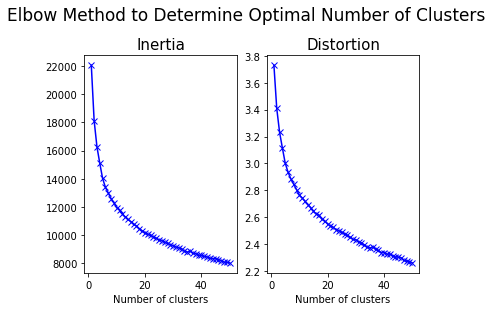

In [53]:
# Now implement KMeans algorithm for different numbers of clusters and then plot the scree plot 
# Since we have more than 2 numeric variables, we will use Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)

inertia = [] # It is the sum of distances of each observation to its cluster center
distortion = [] # It is the average of distances of all observations to its respective cluster center

numiter = range(1,51)
# Iterate over the number of clusters
for i in numiter:
    KMeans_model = KMeans(n_clusters = i, init='k-means++').fit(Xnumeric)
    inertia.append(KMeans_model.inertia_)
    distortion.append(sum(np.min(distance.cdist(Xnumeric, KMeans_model.cluster_centers_, 'euclidean'), axis = 1))/len(Xnumeric))
    
# Now plot the inertia and distortions values
fig = plt.figure()
ax1 = plt.subplot(121)
ax1.plot(numiter, inertia, 'bx-')
ax1.set_title('Inertia', fontsize = 15)
ax1.set_xlabel('Number of clusters', fontsize = 10)
ax2 = plt.subplot(122)
ax2.plot(numiter, distortion, 'bx-')
ax2.set_title('Distortion', fontsize = 15)
ax2.set_xlabel('Number of clusters', fontsize = 10)
plt.suptitle('Elbow Method to Determine Optimal Number of Clusters', fontsize = 17, y = 1.05)
plt.show()

Text(0.5, 1.0, 'Cluster Representation along principal components')

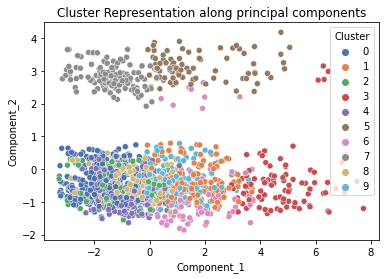

In [71]:
## Now conduct the clustering with only 4 clusters and then plot the cluters 

KMeans_model = KMeans(n_clusters = 10, init = 'k-means++').fit(Xnumeric)
KMeans_label = KMeans_model.labels_

# Now visualize clusters in 2 dimensions using PCA (Could also be done using UMAP)
pca = PCA(n_components = 2).fit_transform(Xnumeric)
pca = pd.DataFrame(pca, columns = ['Component_1','Component_2'])
pca['Cluster'] = KMeans_label

# Now plot using scatter plot
g = sns.scatterplot(data = pca, x = 'Component_1', y = 'Component_2', hue = 'Cluster', palette = 'deep')
g.set_title('Cluster Representation along principal components')

### (2) KMeans Implementation for Numeric Variables + One-Hot Encoded Categorical Variables

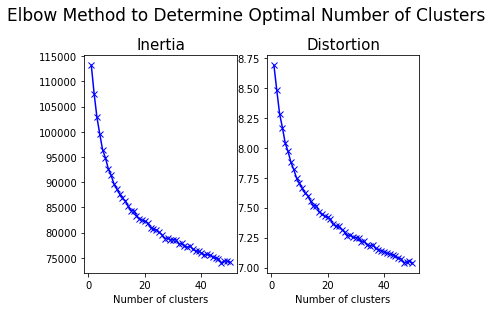

In [78]:
# Concatenate the standardized numeric variables with the standardied one-hot encoded categorical variables

Xnumeric_alt = pd.concat([pd.DataFrame(Xnumeric), pd.DataFrame(StandardScaler().fit_transform(pd.get_dummies(Xcategorical)))], axis = 1)

inertia = [] # It is the sum of distances of each observation to its cluster center
distortion = [] # It is the average of distances of all observations to its respective cluster center

numiter = range(1,51)
# Iterate over the number of clusters
for i in numiter:
    KMeans_model = KMeans(n_clusters = i, init='k-means++').fit(Xnumeric_alt)
    inertia.append(KMeans_model.inertia_)
    distortion.append(sum(np.min(distance.cdist(Xnumeric_alt, KMeans_model.cluster_centers_, 'euclidean'), axis = 1))/len(Xnumeric_alt))
    
# Now plot the inertia and distortions values
fig = plt.figure()
ax1 = plt.subplot(121)
ax1.plot(numiter, inertia, 'bx-')
ax1.set_title('Inertia', fontsize = 15)
ax1.set_xlabel('Number of clusters', fontsize = 10)
ax2 = plt.subplot(122)
ax2.plot(numiter, distortion, 'bx-')
ax2.set_title('Distortion', fontsize = 15)
ax2.set_xlabel('Number of clusters', fontsize = 10)
plt.suptitle('Elbow Method to Determine Optimal Number of Clusters', fontsize = 17, y = 1.05)
plt.show()

Text(0.5, 1.0, 'Cluster Representation along principal components')

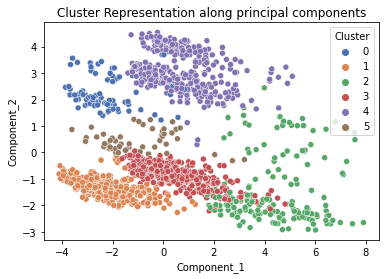

In [81]:
# Now show the cluster representation for acertain number of clusters again along two main principal components

KMeans_model = KMeans(n_clusters = 6, init = 'k-means++').fit(Xnumeric_alt)
KMeans_label = KMeans_model.labels_

# Now visualize clusters in 2 dimensions using PCA (Could also be done using UMAP)
pca = PCA(n_components = 2).fit_transform(Xnumeric_alt)
pca = pd.DataFrame(pca, columns = ['Component_1','Component_2'])
pca['Cluster'] = KMeans_label

# Now plot using scatter plot
g = sns.scatterplot(data = pca, x = 'Component_1', y = 'Component_2', hue = 'Cluster', palette = 'deep')
g.set_title('Cluster Representation along principal components')

### (3) K-Prototype Implementation for both Numeric and Categorical Data

In [101]:
## First concatenate the two types of data and then find the index of the columns of the categorical variables

X_alt = pd.concat([pd.DataFrame(Xnumeric), pd.DataFrame(Xcategorical)], axis = 1)
catColumnsLoc = [X_alt.columns.get_loc(col) for col in list(X_alt.select_dtypes('category').columns)]

# Now convert the dataframe into a matrix
X_alt_matrix = X_alt.to_numpy()

# Now use the elbow method
cost = []
for cluster in range(1,21):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
    kprototype.fit_predict(X_alt_matrix, categorical = catColumnsLoc)
    cost.append(kprototype.cost_)
    print('Cluster Initialization: {}'.format(cluster))

        

Cluster Initialization: 1
Cluster Initialization: 2
Cluster Initialization: 3
Cluster Initialization: 4
Cluster Initialization: 5
Cluster Initialization: 6
Cluster Initialization: 7
Cluster Initialization: 8
Cluster Initialization: 9
Cluster Initialization: 10
Cluster Initialization: 11
Cluster Initialization: 12
Cluster Initialization: 13
Cluster Initialization: 14
Cluster Initialization: 15
Cluster Initialization: 16
Cluster Initialization: 17
Cluster Initialization: 18
Cluster Initialization: 19
Cluster Initialization: 20


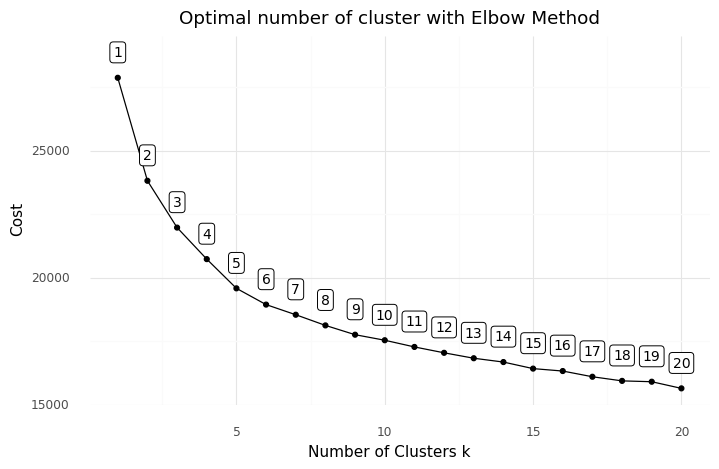

<ggplot: (19376553)>

In [103]:
# Plotting the cost function with the number of clusters chosen 

costK = pd.DataFrame({'Cluster':range(1,21),'Cost':cost})
plotnine.options.figure_size = (8,4.8)
(
    ggplot(data = costK)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)